# 1. Imports

In [18]:
import os
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import plot_confusion_matrix

In [22]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, Dropout
from keras.regularizers import l2

# 2. Data Loading

In [5]:
parent_dir = os.path.dirname(os.getcwd())
features_path = os.path.join(parent_dir, 'dataset', 'features.csv')
df_with_features = pd.read_csv(features_path, index_col=0)
print(df_with_features.shape)
print(df_with_features.type.value_counts())
df_with_features.head()

(651191, 22)
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64


,url,type,use_of_ip,abnormal_url,count_.,count_www,count_@,count_dir,count_embed_domain,short_url,...,count_%,count_?,count_,count_=,url_length,hostname_length,sus_url,fd_length,tld_length,type_code
0,br-icloud.com.br,phishing,0,0,2,0,0,0,0,0,...,0,0,1,0,16,0,0,0,-1,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,2,0,0,2,0,0,...,0,0,0,0,35,0,0,5,-1,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,2,0,0,3,0,0,...,0,0,0,0,31,0,0,7,-1,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,3,1,0,1,0,0,...,0,1,1,4,88,21,0,9,2,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,2,0,0,1,0,0,...,0,1,1,3,235,23,0,9,3,1


In [6]:
X = df_with_features.copy(deep=True)
X.drop(['url', 'type', 'type_code'], axis=1, inplace=True)
X.head()

,use_of_ip,abnormal_url,count_.,count_www,count_@,count_dir,count_embed_domain,short_url,count_https,count_http,count_%,count_?,count_,count_=,url_length,hostname_length,sus_url,fd_length,tld_length
0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,16,0,0,0,-1
1,0,0,2,0,0,2,0,0,0,0,0,0,0,0,35,0,0,5,-1
2,0,0,2,0,0,3,0,0,0,0,0,0,0,0,31,0,0,7,-1
3,0,1,3,1,0,1,0,0,0,1,0,1,1,4,88,21,0,9,2
4,0,1,2,0,0,1,0,0,0,1,0,1,1,3,235,23,0,9,3


In [7]:
complete_feature_set = list(X.columns)
print(complete_feature_set)

['use_of_ip', 'abnormal_url', 'count_.', 'count_www', 'count_@', 'count_dir', 'count_embed_domain', 'short_url', 'count_https', 'count_http', 'count_%', 'count_?', 'count_', 'count_=', 'url_length', 'hostname_length', 'sus_url', 'fd_length', 'tld_length']


In [8]:
y = df_with_features.copy(deep=True)
y = y['type_code']
y.head()

0    3
1    0
2    0
3    1
4    1
Name: type_code, dtype: int64

In [9]:
# Construct a hold-out dataset for final testing
X_tune, X_holdout, y_tune, y_holdout = train_test_split(X, y, test_size=0.02, random_state=99)
print(X_tune.shape)
print(X_holdout.shape)
print(y_tune.shape)
print(y_holdout.shape)

(638167, 19)
(13024, 19)
(638167,)
(13024,)


# 3. Cross Validation

The following function can be used to try out a ML algorithm of one's choice to perform n-fold cross validation the training dataset. 
The accuracy for each validation subset is saved in the metrics dictionary, which is returned. 

In [10]:
def train_and_eval(X, y, feature_set=[], models_to_use=[], folds=10):
    """
    Perform cross validation on selected models using given data X and targets y. 
    :param X: the features 
    :param age: the targets 
    :param feature_set: the list of features to use for training 
    :param models_to_use: a list of selected models to be trained
    :param folds: how many folds to use for StratifiedKFold
    :return: a dictionary where the keys are the model names and each value is a list of a 
    accuracies across all folds  
    """
    
    if len(feature_set) != 0:        
        X = X[feature_set]

    random_state = 100
    metrics = {
            'rf':[],
            'dt':[],
            'knn':[],
            'svm':[],
            'lr':[],
            'lda':[],
            'ab':[],
            'nb':[],
            'keras':[],
            }
    
    print('Training with {} features'.format(len(X.columns)))
    print('Using {} fold cross validation'.format(folds))
    skf = StratifiedKFold(n_splits=folds, shuffle=False, random_state=None)
    count = 1

    print("Using models:", models_to_use)

    for train_idx, test_idx in skf.split(X, y):
        print("On fold {}".format(count))
        count += 1
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Instantiate various ML models for training 
        if "rf" in models_to_use:        
            # Random Forest Model
            rf = RandomForestClassifier(random_state=random_state, verbose=2)
            rf.fit(X_train, y_train)
            score = rf.score(X_test, y_test)
            metrics['rf'].append(score)

        if "dt" in models_to_use:
            # Decision Tree Model
            dt = DecisionTreeClassifier(random_state=random_state)
            dt.fit(X_train, y_train)
            score = dt.score(X_test, y_test)
            metrics['dt'].append(score)

        if "knn" in models_to_use:
            # k-Nearest Neighbors Model
            knn = KNeighborsClassifier()
            knn.fit(X_train, y_train)
            score = knn.score(X_test, y_test)
            metrics['knn'].append(score)

        if "svm" in models_to_use:
            # Support Vector Machine Model
            svm = SVC(random_state=random_state, verbose=2)
            svm.fit(X_train, y_train)
            score = svm.score(X_test, y_test)
            metrics['svm'].append(score)

        if "lda" in models_to_use:
            # Linear Discriminant Analysis Model
            lda = LinearDiscriminantAnalysis()
            lda.fit(X_train, y_train)
            score = lda.score(X_test, y_test)
            metrics['lda'].append(score)

        if "ab" in models_to_use:
            # AdaBoost Model
            ab = AdaBoostClassifier(random_state=random_state)
            ab.fit(X_train, y_train)
            score = ab.score(X_test, y_test)
            metrics['ab'].append(score)

        if "nb" in models_to_use:
            # Naive Bayes Model
            nb = GaussianNB()
            nb.fit(X_train, y_train)
            score = nb.score(X_test, y_test)
            metrics['nb'].append(score)
        
        if "dnn" in models_to_use:
            # Keras-TensorFlow DNN Model
            dnn_keras = Sequential(layers=[
                    Dense(64, kernel_regularizer=l2(0.001), activation='relu',input_shape=(len(X_train.columns),)),
                    BatchNormalization(),
                    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
                    BatchNormalization(),
                    Dense(y_train.nunique(), activation='softmax')
            ])
            print(dnn_keras.summary())
            dnn_keras.compile(
                optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
            dnn_keras.fit(X_train, pd.get_dummies(y_train), epochs=10, verbose=1, batch_size=256)
            _, score = dnn_keras.evaluate(X_test, pd.get_dummies(y_test), verbose=1)
            metrics['keras'].append(score)

    return metrics

In [ ]:
features_to_use = ['count_.', 'count_www', 'count_@', 'count_dir', 
                    'count_https', 'count_http', 'count_%', 'count_?', 'count_', 'count_=',]
# Train on the entire feature set, using decision tree approach. 
models_to_use = ["rf"]
metrics = train_and_eval(X=X_tune, y=y_tune, feature_set=features_to_use ,models_to_use=models_to_use)

Here we can see that the our approach can do well on unseen data, since we are using stratefied-k-fold validation without unique splits. The validation accuracy across each of the 10 groups are very similar. 

In [12]:
for model_name in models_to_use:
    print("{}: {}".format(model_name, metrics[model_name]))
    print()

rf: [0.9293448454173653, 0.9299402980397072, 0.9289531002710877, 0.927527147938637, 0.9303633827976872, 0.9295642226992807, 0.9281539401726813, 0.9295317788642347, 0.9290773473736994, 0.927682712799298]



In [13]:
models_to_use = ["dt"]
metrics = train_and_eval(X=X_tune, y=y_tune, feature_set=features_to_use ,models_to_use=models_to_use)

Training with 10 features
Using 10 fold cross validation
Using models: ['dt']
On fold 1
On fold 2
On fold 3
On fold 4
On fold 5
On fold 6
On fold 7
On fold 8
On fold 9
On fold 10


In [14]:
for model_name in models_to_use:
    print("{}: {}".format(model_name, metrics[model_name]))
    print()

dt: [0.9288120720184276, 0.929595562310983, 0.9282479590077879, 0.9268063368694862, 0.929752260369494, 0.9288747512418322, 0.9274331291035304, 0.9290773473736994, 0.9284662153691864, 0.927275291462956]



The performance of Random Forest is very similar to that of Decision Tree. 

In [16]:
# Now train the dataset on the entire training set, and evaluate on the holdout dataset. 
final_dt = DecisionTreeClassifier()
final_dt.fit(X_tune, y_tune)
y_pred = final_dt.predict(X_holdout)
print(classification_report(y_holdout, y_pred))
score = accuracy_score(y_holdout, y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      8594
           1       0.98      0.98      0.98      1922
           2       0.97      0.96      0.96       638
           3       0.89      0.84      0.86      1870

    accuracy                           0.96     13024
   macro avg       0.95      0.94      0.95     13024
weighted avg       0.96      0.96      0.96     13024

accuracy:   0.961


- Benign: 0,
- Defacement: 1,
- Malware: 2,
- Phishing: 3


# 4. Analyis

Total samples in holdout set: 13024
type_code
0            8594
1            1922
3            1870
2             638
dtype: int64


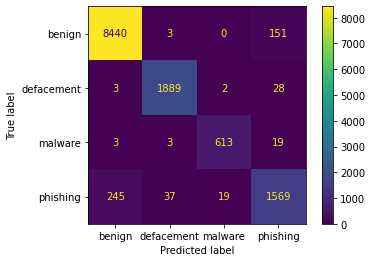

In [17]:
print("Total samples in holdout set: {}".format(y_holdout.shape[0]))
print(y_holdout.to_frame().value_counts())
plot_confusion_matrix(final_dt, X_holdout, y_holdout, display_labels=['benign', 'defacement', 'malware', 'phishing'])
plt.show()

We can see that both precision and recall for **benign**, **defacement**, and **malware** type urls are relatively high compared to those for **phishing** urls. Based on the confusion matrix, we see that 13% of **phishing** emails were classified as benign. This is the most prominent weakness of this particular model. 

In [24]:
start_time = time.time()
importances = final_dt.feature_importances_
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.024 seconds


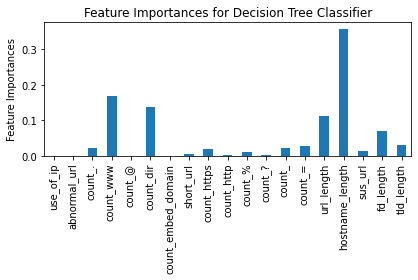

In [25]:
importances = pd.Series(importances, index=complete_feature_set)
fig, ax = plt.subplots()
importances.plot.bar(ax=ax)
ax.set_title("Feature Importances for Decision Tree Classifier")
ax.set_ylabel("Feature Importances")
fig.tight_layout()

The host name's length seems by far to be most important feature for the decision tree classifier. Features such as use_of_ip, abnormal_url, and count_@ weren't relevant for the decision tree classifier.